In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import solve_banded
from scipy.linalg import lu_factor, lu_solve

In [2]:
def hh_gating(V, dt, curr_gate, T):
    # Calculate gating variables

    # Alpha and beta rate equations
    alpha = np.zeros((100, 3))
    beta = np.zeros((100, 3))

    alpha[:, 0] = 1e3 * ((2.5 - 100 * V) / (np.exp(2.5 - 100 * V) - 1))
    beta[:, 0] = 4e3 * np.exp(-500 * V / 9)

    alpha[:, 1] = 1000 * ((0.1 - 10 * V) / (np.exp(1 - 100 * V) - 1))
    beta[:, 1] = 125 * np.exp(-25 * V / 2)

    alpha[:, 2] = 70 * np.exp(-50 * V)
    beta[:, 2] = 1000 / (np.exp(3 - 100 * V) + 1)

    # Temperature correction
    temperature_correction = 3**(0.1 * (T - 6.3))

    # A and B coefficients for exponential solver
    A = -temperature_correction * (alpha + beta)
    B = temperature_correction * alpha

    # Calculate gating variables m, n, h for the future timestep using the exponential Euler solver
    new_gates = curr_gate * np.exp(A * dt) + (B / A) * (np.exp(A * dt) - 1)

    return new_gates

In [3]:
def hh_potential(V, dt, I_ions, I_stim):
    # Calculate new membrane potential

    # Constants
    membrane_capacitance = 1e-6
    axoplasmic_resistance = 1
    axon_radius = 2e-6
    compartment_length = 0.1e-6
    resistance_axon = (axoplasmic_resistance * compartment_length) / (np.pi * axon_radius**2)

    # Matrices
    ones_vector = np.ones(100)
    diagonal_0 = -2 * ones_vector
    diagonal_1 = np.ones(99)

    C = np.diag(diagonal_1, -1) + np.diag(diagonal_0, 0) + np.diag(diagonal_1, 1)
    C[0, 0] = -1
    C[-1, -1] = -1

    I_identity = np.eye(100)
    I_HH = np.sum(I_ions, axis=1)

    # Set up the system of equations
    A_dense = I_identity - ((dt / (membrane_capacitance * resistance_axon)) * C)

    # Right-hand side of the implicit Euler method
    rhs = V + ((dt / membrane_capacitance) * (-I_HH + I_stim))

    # Use NumPy's solve to solve the system of equations implicitly
    V_new = np.linalg.solve(A_dense, rhs)

    return V_new

In [4]:
def hh_model(I_stim, t_end, dt, T):
    # Definitions and constants
    m = 100

    Vrest = 0e-3
    t = np.arange(0, t_end, dt)

    V_Na = 115e-3
    V_K = -12e-3
    V_L = 10.6e-3

    g_Na = 120e-3
    g_K = 36e-3
    g_L = 0.3e-3

    alpha_m = lambda V: 1000 * ((2.5 - 100 * V) / (np.exp(2.5 - 100 * V) - 1))
    beta_m = lambda V: 4000 * np.exp(-500 * V / 9)

    alpha_n = lambda V: 1000 * ((0.1 - 10 * V) / (np.exp(1 - 100 * V) - 1))
    beta_n = lambda V: 125 * np.exp(-25 * V / 2)

    alpha_h = lambda V: 70 * np.exp(-50 * V)
    beta_h = lambda V: 1000 / (np.exp(3 - 100 * V) + 1)

    alpha_0 = np.zeros((m, 3))
    beta_0 = np.zeros((m, 3))

    V = np.zeros((m, len(t)))
    gates = np.zeros((m, 3, len(t)))
    I_ions = np.zeros((m, 3, len(t)))

    # Initial calculations
    for j in range(m - 1):
        V[j, 0] = Vrest

        alpha_0[j, 0] = alpha_m(V[0, 0])
        alpha_0[j, 1] = alpha_n(V[0, 0])
        alpha_0[j, 2] = alpha_h(V[0, 0])

        beta_0[j, 0] = beta_m(V[0, 0])
        beta_0[j, 1] = beta_n(V[0, 0])
        beta_0[j, 2] = beta_h(V[0, 0])

        for i in range(3):
            gates[j, i, 0] = alpha_0[j, i] / (alpha_0[j, i] + beta_0[j, i])

    # Iterative calculation of the membrane potential
    for i in range(len(t) - 1):
        gates[:, :, i + 1] = hh_gating(V[:, i], dt, gates[:, :, i], T)
        
        I_ions[:, 0, i + 1] = g_Na * (gates[:, 0, i + 1] ** 3) * gates[:, 2, i + 1] * (V[:, i] - V_Na)
        I_ions[:, 1, i + 1] = g_K * (gates[:, 1, i + 1] ** 4) * (V[:, i] - V_K)
        I_ions[:, 2, i + 1] = g_L * (V[:, i] - V_L)

        V[:, i + 1] = hh_potential(V[:, i], dt, I_ions[:, :, i + 1], I_stim[:, i + 1])

    return V, gates, I_ions, t

In [5]:
# Define parameters
t_end = 100e-3
dt = 25e-6
T = 6.3
m = np.arange(1, 101)

# Create two stimulation currents
t0 = np.arange(0, t_end, dt)
td = np.arange(0, 5e-3, dt)
t1 = np.arange(5e-3, t_end, dt)
t2 = np.arange(15e-3, t_end, dt)

stim_ex1 = np.concatenate((np.zeros(len(t0) - len(t1)), 5e-6 * np.ones(len(td)), np.zeros(len(t1) - len(td))))
stim_ex2 = np.concatenate((5e-6 * np.ones(len(td)), np.zeros(len(t0) - len(td))))
stim_ex3 = np.concatenate((np.zeros(len(t0) - len(t2)), 5e-6 * np.ones(len(td)), np.zeros(len(t2) - len(td))))

I_stim1 = np.zeros((100, len(t0)))
I_stim1[99, :] = stim_ex1

I_stim2 = np.zeros((100, len(t0)))
I_stim2[19, :] = stim_ex2
I_stim2[79, :] = stim_ex3

# Run the hh_model function
V1, gates1, I_ions1, t = hh_model(I_stim1, t_end, dt, T)
V2, gates2, I_ions2, t2 = hh_model(I_stim2, t_end, dt, T)

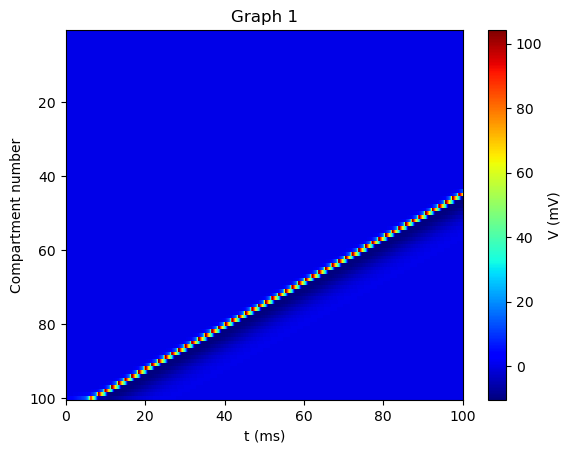

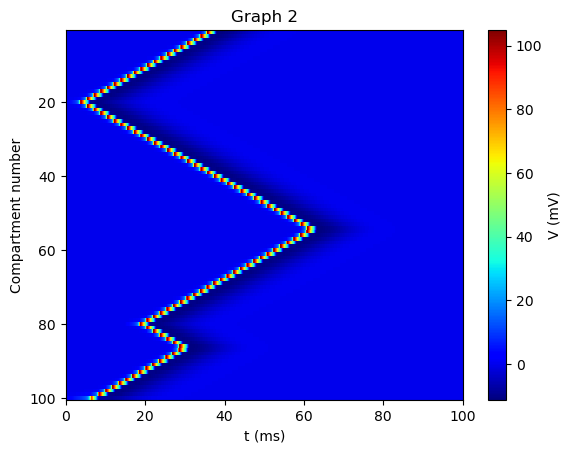

In [6]:
# Plot the results for inverted color map and y-axis
fig, ax = plt.subplots()
c = ax.pcolormesh(t * 1e3, m, V1 * 1e3, cmap='jet')  # Invert color map here
ax.invert_yaxis()  # Invert y-axis here
ax.set_xlim([0, 100])
ax.set_xlabel("t (ms)")
ax.set_ylabel("Compartment number")
ax.set_title("Graph 1")
fig.colorbar(c, label="V (mV)")
plt.savefig('graph1.png', format='png')

fig, ax = plt.subplots()
c = ax.pcolormesh(t * 1e3, m, V2 * 1e3, cmap='jet')  # Invert color map here
ax.invert_yaxis()  # Invert y-axis here
ax.set_xlim([0, 100])
ax.set_xlabel("t (ms)")
ax.set_ylabel("Compartment number")
ax.set_title("Graph 2")
fig.colorbar(c, label="V (mV)")
plt.savefig('graph2.png', format='png')

plt.show()